In [4]:
devtools::install_github("clairbarnes/rwwa")
library(rwwa)

regions = c('org', 'lv', 'lt', 'tc', 'box', 'ch', 'vt') 
datasets <- c("chirps", "cpc", "era5", "mswep", "tamsat")
varnm <- "rx30day"

Skipping install of 'rwwa' from a github remote, the SHA1 (a428e9e0) has not changed since last install.
  Use `force = TRUE` to force installation

Loading required package: extRemes

Loading required package: Lmoments

Loading required package: distillery


Attaching package: ‘extRemes’


The following objects are masked from ‘package:stats’:

    qqnorm, qqplot


Loading required package: plyr


Attaching package: ‘plyr’


The following object is masked from ‘package:distillery’:

    is.formula




# Fit linear trend to all obs

## GMST only

In [2]:
gmst = read.table("ts_obs/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

# define factual & counterfactual covariates
cov_2024 <- gmst[gmst$year == 2024,c("gmst"), drop = F]
cov_cf <- cov_2024 - 1.2

In [3]:
# Bootstrap results - GMST only
for (region in regions) {
    for (ds in datasets[1]) {

        nsamp <- switch(region, "org" = 1000, 100)
        
        fnm <- paste0("ts_obs/EA-floods_",varnm,"_obs-",region,"_",ds,".dat")
        res_fnm <- gsub(".dat", ".csv", gsub("ts_obs/", paste0("res/",region,"/res-gmst_"), fnm))
        # if(!file.exists(res_fnm)) {
            ts <- load_ts(fnm, col.names = c("year", "pr"))
            df <- merge(gmst, ts)

            mdl <- fit_ns("gev", "fixeddisp", df, "pr", c("gmst"), lower = F)
            res <- boot_ci(mdl, cov_f = cov_2024, cov_cf = cov_cf, nsamp = nsamp)                                 
            write.csv(res, res_fnm)
        # }
    }
}

In [4]:
# compile obs
for (region in regions) {
    fl = list.files(paste0("res/",region), pattern = "gmst.+obs", full.names = T)
    obs_res <- data.frame(t(sapply(fl, function(fnm) {
        res <- read.csv(fnm, row.names = "X")
        unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
    })))
    rownames(obs_res) <- sapply(strsplit(gsub(".csv","",rownames(obs_res)), "_"), "[", 5)
    write.csv(obs_res, paste0("res/res-obs_gmst_",region,".csv"))
}

### Parameter estimates

In [5]:
# load all the bootstrapped results (maybe not for all regions)
regions = c('org', 'lt', 'lv', 'ch', 'tc') 

all_res <- abind::abind(sapply(regions, function(rnm) {
    abind::abind(sapply(datasets, function(ds) {
        read.csv(paste0("res/",rnm,"/res-gmst_EA-floods_rx30day_obs-",rnm,"_",ds,".csv"), row.names = "X")
    }, simplify = F), along = 0)
}, simplify = F), along = 0)[,,1:10,]

In [9]:
plot_pars <- c("alpha_gmst", "return_period", "PR", "dI_rel", "dI_abs")
ds_colours <- c("red", "blue", "forestgreen", "purple", "turquoise4", "pink", "gold")

prep_window(c(1,4), h = 4.5, w = 5); 

png("fig/par-ests_gmst.png", height = 240, w = 4 * 240 * 5/4); par(cex.main = 1.4, mar = c(8,3,3,1)); {
    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        res <- all_res[,,r,]
        res[!is.finite(res)] <- NA
        ylim = range(res, na.rm = T)
        logaxs = ""
        h = 0
        
        res <- aperm(res, c(2,1,3))
        
        nc <- ncol(res)
        nr <- nrow(res)
        
        nr <- nrow(res)
        if(grepl("alpha", r)) {
            ylim = range(pretty(all_res[,,grepl("alpha", dimnames(all_res)[[3]]),]), na.rm = T)
        } else if(grepl("dI_abs", r)) {
            ylim = range(pretty(all_res[,,grepl("dI_abs", dimnames(all_res)[[3]]),]), na.rm = T)
        } else if(grepl("dI_rel", r)) {
            ylim = range(pretty(all_res[,,grepl("dI_rel", dimnames(all_res)[[3]]),]), na.rm = T)
        } else if(grepl("return_period", r)) {
            ylim = c(0,50)
        } else if(grepl("PR", r)) {
            h = 1
            logaxs = "y"
            ylim = exp(range(pretty(log(all_res[,,grepl("PR", dimnames(all_res)[[3]]),])), na.rm = T))
            ylim = c(1/100, 100)
        }
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,nr*(nc+1)), main = r, xaxt = "n", xlab = "", ylab = "", log = logaxs)
        axis(1, at = (1:nr)*(nc+1) - (nc+1)/2, labels = rownames(res), las = 2)
        
        for (i in 1:nr) {
            x <- ((i-1)*(nc+1))+(1:nc)
            segments(x0 = x, y0 = res[i,,"X2.5."], y1 = res[i,,"X97.5."], lwd = 8, col = adjustcolor(ds_colours, alpha = 0.4))
            points(x, res[i,,"est"], pch = 21, cex = 1.5, bg = ds_colours)
        }
        abline(h = h, lty = 2)
            
        abline(v = (0:nr)*(nc+1), col = adjustcolor("black", alpha = 0.3))
    }
    legend("topleft", legend = colnames(res), fill = adjustcolor(ds_colours, alpha = 0.4), border = NA, ncol = 2)
}; dev.off()

### Trend plots (original region)

In [156]:
gmst = read.table("ts_obs/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

# define factual & counterfactual covariates
cov_2024 <- gmst[gmst$year == 2024,c("gmst"), drop = F]
cov_cf <- cov_2024 - 1.2

In [158]:
models <- sapply(datasets, function(ds) {
    df <- merge(gmst, load_ts(paste0("ts_obs/EA-floods_rx30day_obs-org_",ds,".dat"), col.names = c("year", "pr")))
    fit_ns("gev", "fixeddisp", df, "pr", c("gmst"), lower = F)
}, simplify = F)

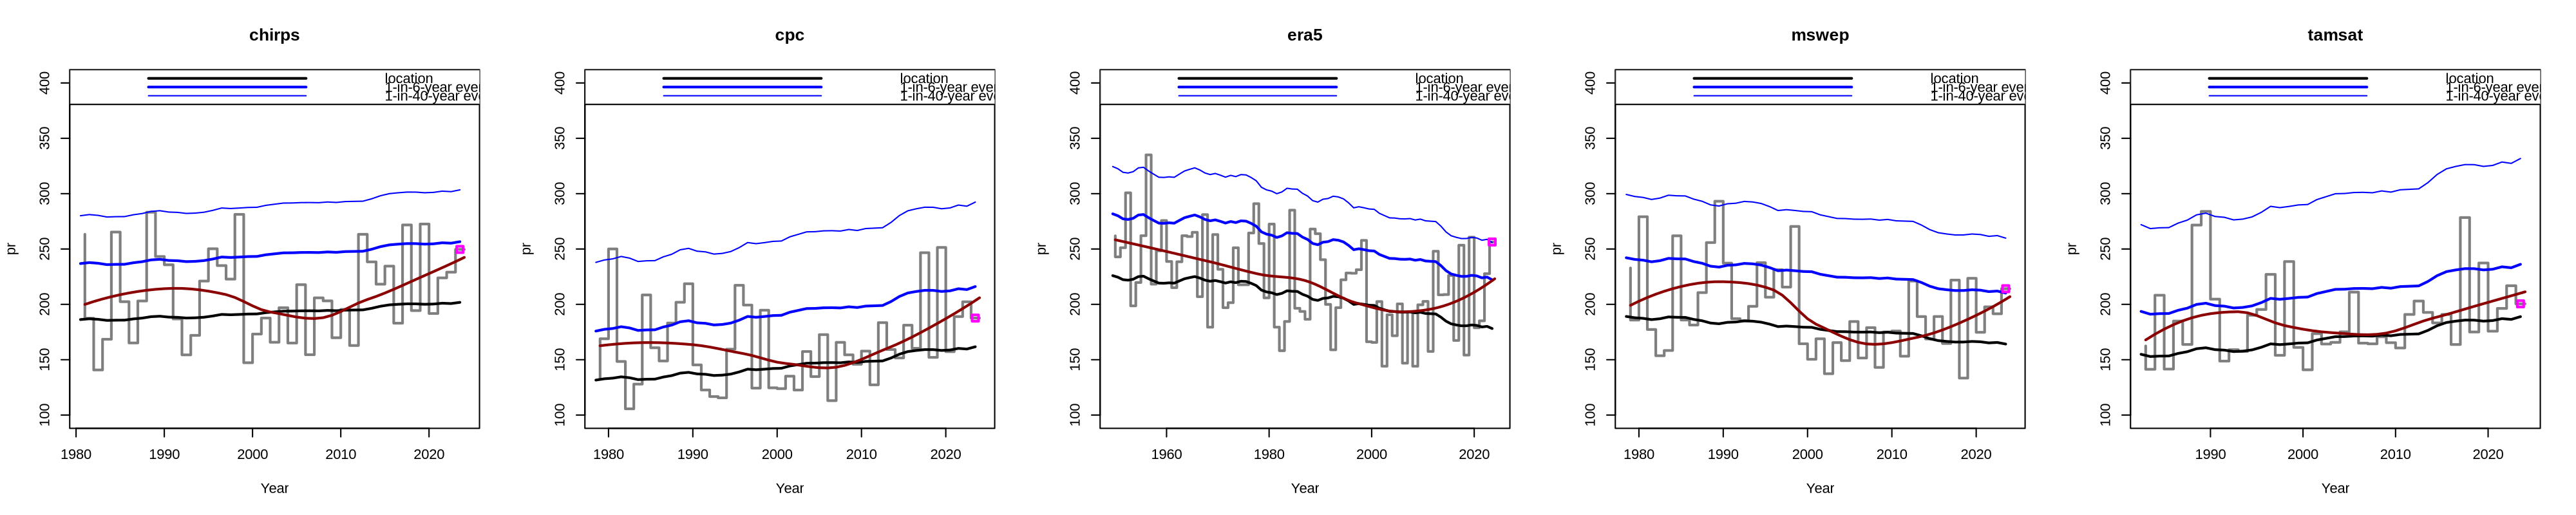

In [160]:
prep_window(c(1,5))
ylim <- c(100,400)

for (ds in datasets) {
    mdl <- models[[ds]]
    plot_trend(mdl, ylim = ylim, main = ds)
    lines(mdl$data$year, fitted(loess(pr ~ year, mdl$data)), col = "darkred", lw = 2)
}

## The East Africa Paradox

In [132]:
gmst = read.table("ts_obs/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

sstg <- read.csv("data/sst-gradient-sm4y.csv", col.names = c("year", "gradient"))
gph <- read.csv("data/850hPa-geopotential-height.csv", col.names = c("year", "gph"))
gph$year <- gph$year + 1

chirps <- load_ts("ts_obs/EA-floods_rx30day_obs-org_chirps.dat", col.names = c("year", "pr"))
cpc <- load_ts("ts_obs/EA-floods_rx30day_obs-org_cpc.dat", col.names = c("year", "pr"))
era5 <- load_ts("ts_obs/EA-floods_rx30day_obs-org_era5.dat", col.names = c("year", "pr"))
mswep <- load_ts("ts_obs/EA-floods_rx30day_obs-org_mswep.dat", col.names = c("year", "pr"))
tamsat <- load_ts("ts_obs/EA-floods_rx30day_obs-org_tamsat.dat", col.names = c("year", "pr"))

ls <- 0.5
gph$gph_sm <- fitted(loess(gph ~ year, gph, span = ls))
sstg$gradient_sm <- fitted(loess(gradient ~ year, sstg, span = ls))
gph$gph_sc <- scale(c(gph$gph))
sstg$gradient_sc <- scale(c(sstg$gradient))

In [206]:
for (rnm in c("org", "box", "lt", "lv", "ch", "tc")) {
    prep_window(c(1,5), h = 2, w = 3)

    png(paste0("fig/obs-trend_",rnm,".png"), height = 240, width = 240 * 4/3 * 5); par(mfrow = c(1,5), cex.main = 1.4, cex.lab = 1.5, cex.axis = 1.4); {
        par(mar = c(2,2,3,1), oma = c(0,2,0,0))
        for (ds in datasets) {
            df <- load_ts(paste0("ts_obs/EA-floods_rx30day_obs-",rnm,"_",ds,".dat"), col.names = c("year", "pr"))
            plot(df$year, df$pr, type = "S", lwd = 2, col = adjustcolor("black", 0.3), main = ds, ylim = c(0,500), xlim = c(1950,2024))
            lines(df$year, fitted(loess(pr ~ year, df, span = 0.5)), lwd = 2)
        }
        mtext("Precip (mm)", side = 2, outer = T, line = 0.5)
    }; dev.off()
}



In [9]:
df <- merge(merge(merge(gmst, sstg), gph), chirps)

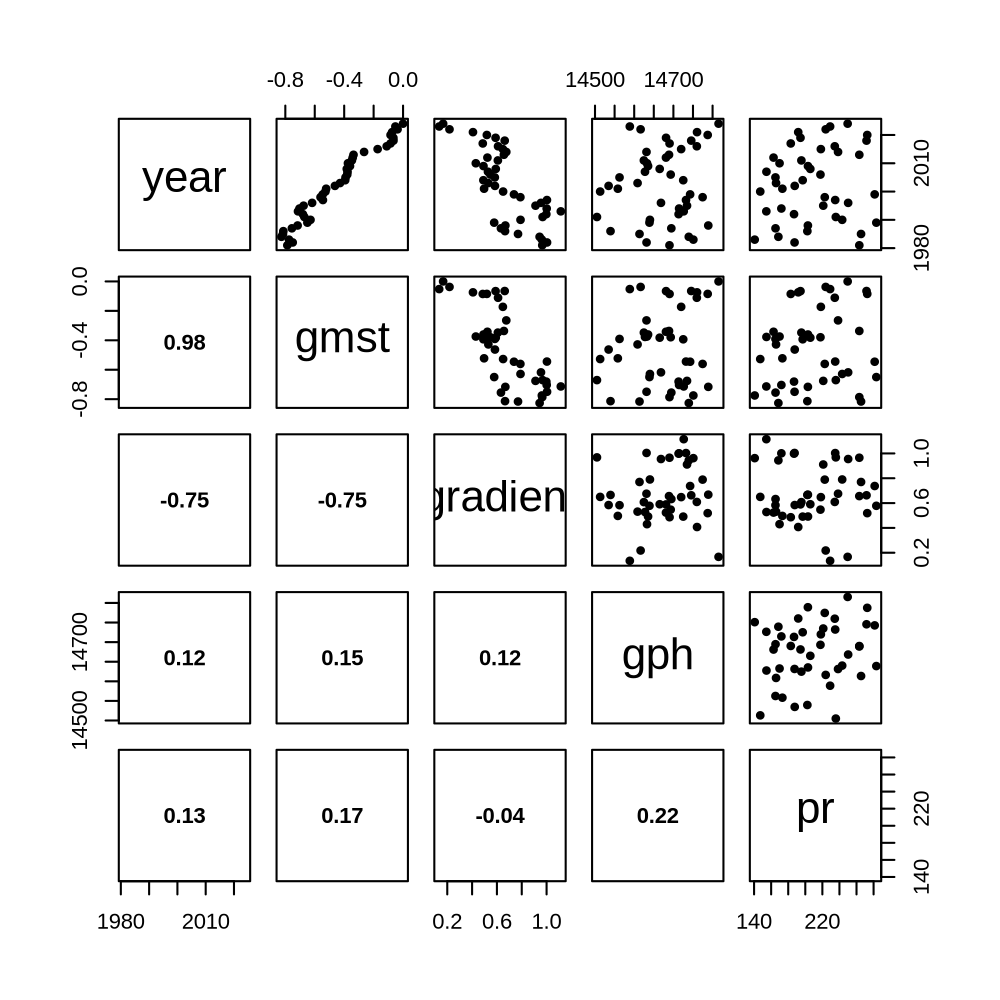

In [10]:
prep_window(h = 5, w = 5)
pairs(df, lower.panel = panel.cor)

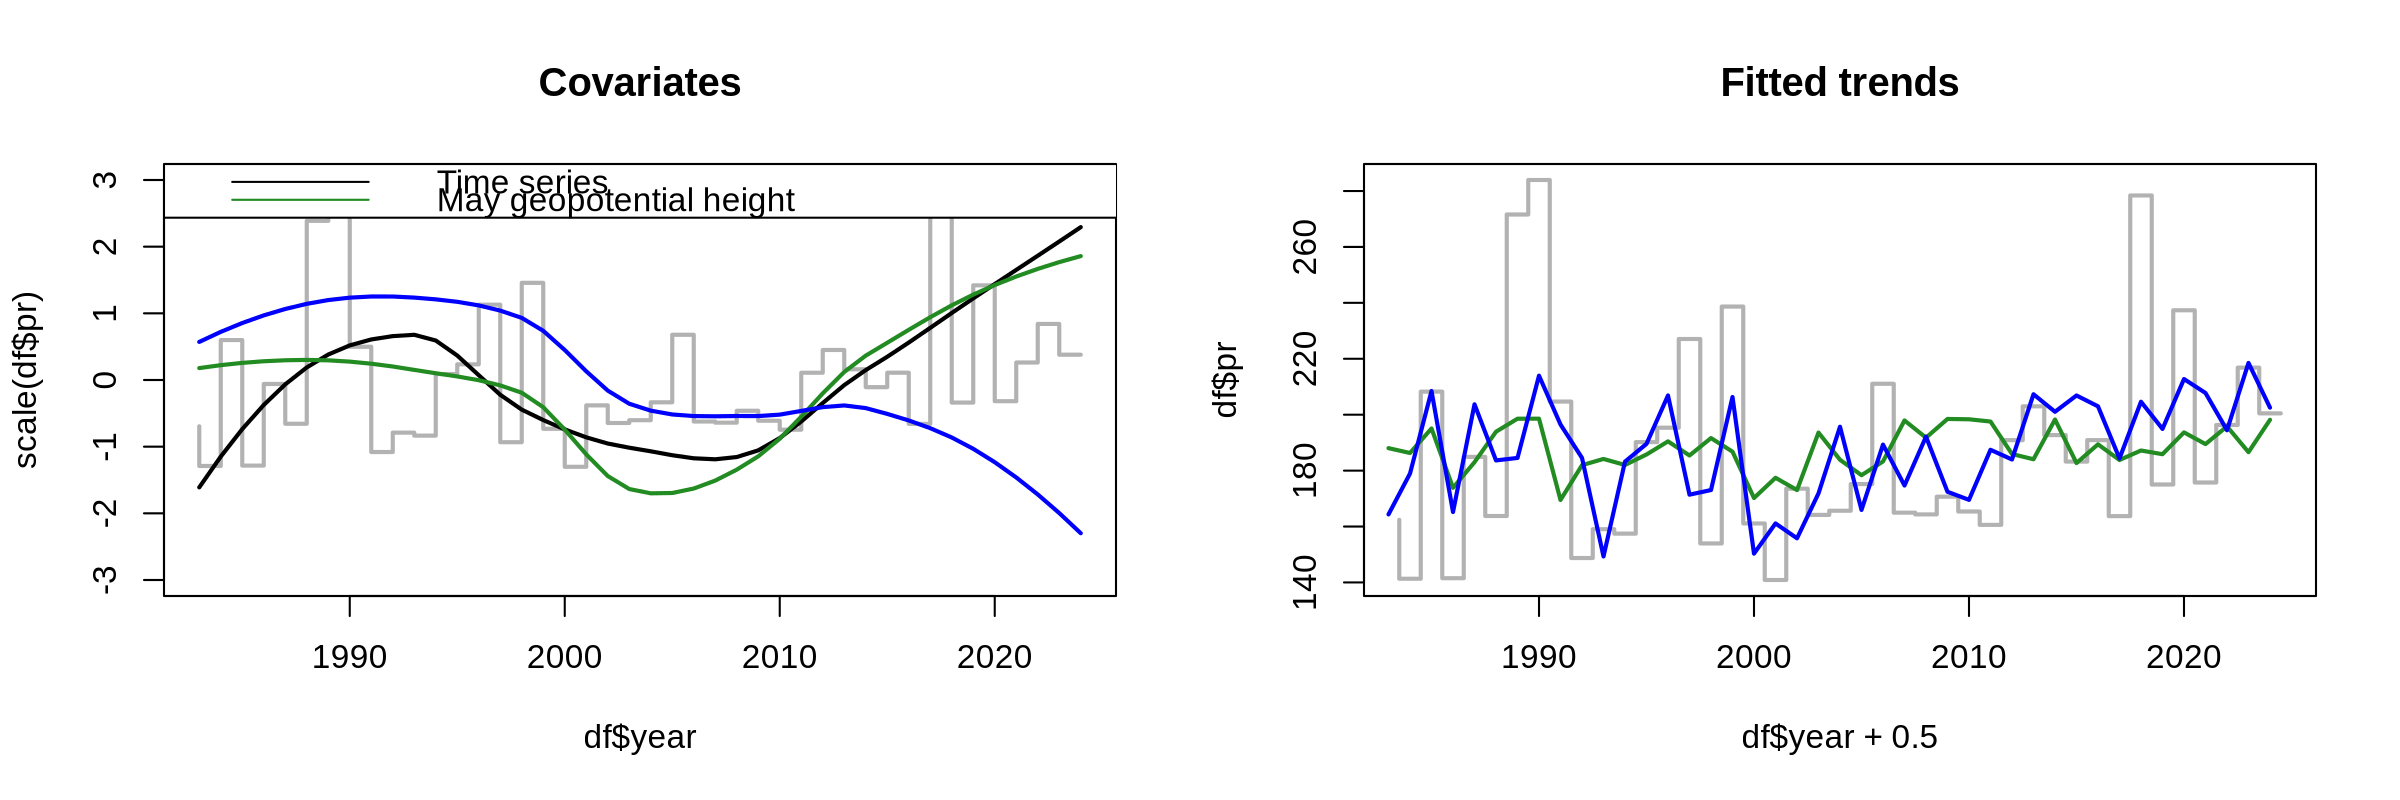

In [64]:
prep_window(c(1,2), h = 4, w = 6)

plot(df$year, scale(df$pr), type = "S", lwd = 2, ylim = c(-3,3), col = adjustcolor("black", 0.3), main = "Covariates")
lines(df$year, scale(fitted(loess(pr ~ year, df, span = ls))), col = "black", lwd = 2)
lines(df$year, scale(gph$gph_sm), col = "forestgreen", lwd = 2)
lines(df$year, scale(gradient_sm), col = "blue", lwd = 2)

legend("topleft", legend = c("Time series", "May geopotential height"), col = c("black", "forestgreen", "blue"), lty = 1)

plot(df$year+0.5, df$pr, type = "S", lwd = 2, col = adjustcolor("black", 0.3), main = "Fitted trends")
lines(df$year, fitted(loess(pr ~ gph, df, span = ls)), col = "forestgreen", lwd = 2)
lines(df$year, fitted(loess(pr ~ gph + gradient, df, span = ls)), col = "blue", lwd = 2)

In [85]:
gmst = read.table("ts_obs/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

sstg <- read.csv("data/sst-gradient-sm4y.csv", col.names = c("year", "gradient"))
gph <- read.csv("data/850hPa-geopotential-height.csv", col.names = c("year", "gph"))
gph$year <- gph$year + 1

chirps <- load_ts("ts_obs/EA-floods_rx30day_obs-org_chirps.dat", col.names = c("year", "pr"))
cpc <- load_ts("ts_obs/EA-floods_rx30day_obs-org_cpc.dat", col.names = c("year", "pr"))
era5 <- load_ts("ts_obs/EA-floods_rx30day_obs-org_era5.dat", col.names = c("year", "pr"))
mswep <- load_ts("ts_obs/EA-floods_rx30day_obs-org_mswep.dat", col.names = c("year", "pr"))
tamsat <- load_ts("ts_obs/EA-floods_rx30day_obs-org_tamsat.dat", col.names = c("year", "pr"))

ls <- 0.5
gph$gph_sm <- fitted(loess(gph ~ year, gph, span = ls))
sstg$gradient_sm <- fitted(loess(gradient ~ year, sstg, span = ls))

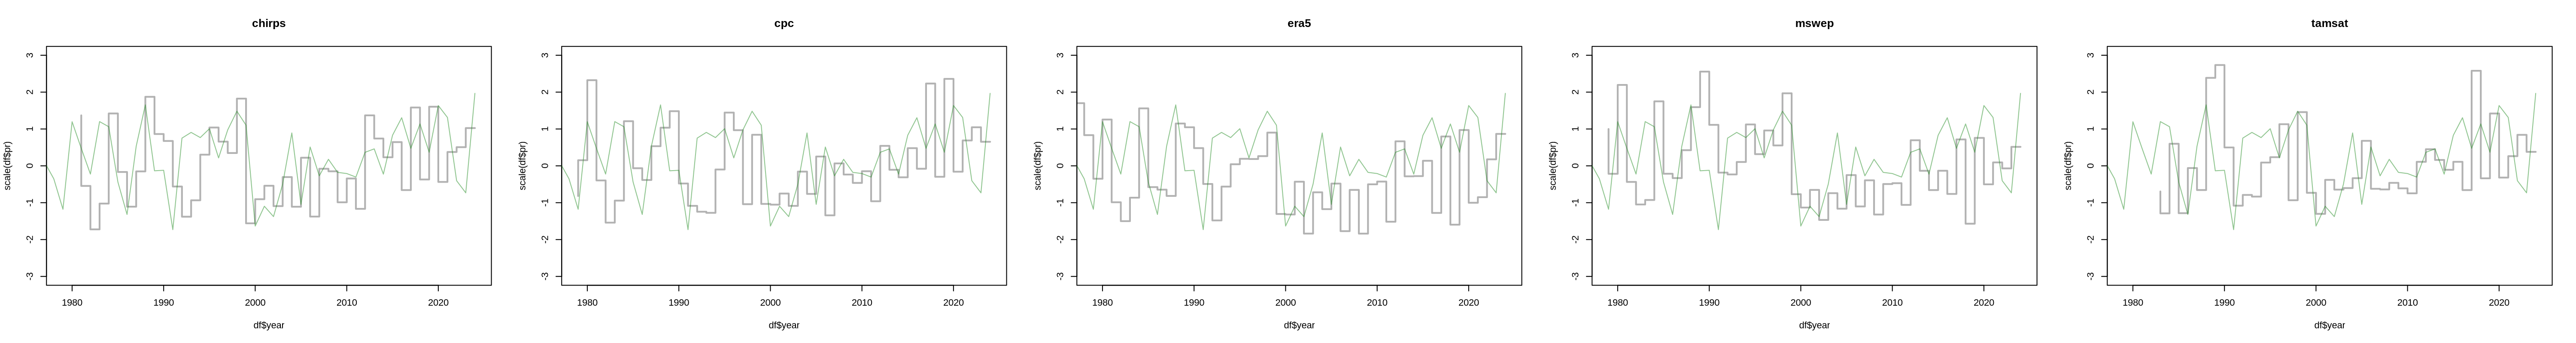

In [92]:
prep_window(c(1,5), h = 4, w = 6)

for (ds in datasets) {
    df <- merge(merge(merge(gmst, sstg), gph), get(ds))
    plot(df$year, scale(df$pr), type = "S", lwd = 2, ylim = c(-3,3), col = adjustcolor("black", 0.3), main = ds, xlim = c(1979,2024))
#     lines(df$year, scale(fitted(loess(pr ~ year, df, span = ls))), col = "black", lwd = 2)
    lines(gph$year, scale(gph$gph), col = adjustcolor("forestgreen", alpha = 0.5))
#     lines(gph$year, scale(gph$gph_sm), col = "forestgreen", lwd = 2)
#     lines(sstg$year, scale(sstg$gradient_sm), col = "blue", lwd = 2)
}

In [84]:
gph_sm

[1] 14676.76 14677.91 14678.80 14679.43 14679.82 14679.96 14679.79 14679.29
 [9] 14678.47 14677.39 14676.06 14674.75 14673.51 14672.03 14670.01 14667.15
[17] 14661.50 14652.77 14643.10 14634.66 14629.59 14627.91 14628.05 14629.78
[25] 14632.89 14637.15 14642.35 14649.21 14657.81 14666.91 14675.26 14681.63
[33] 14686.66 14691.70 14696.62 14701.25 14705.44 14709.16 14712.49 14715.46
[41] 14718.10 14720.45

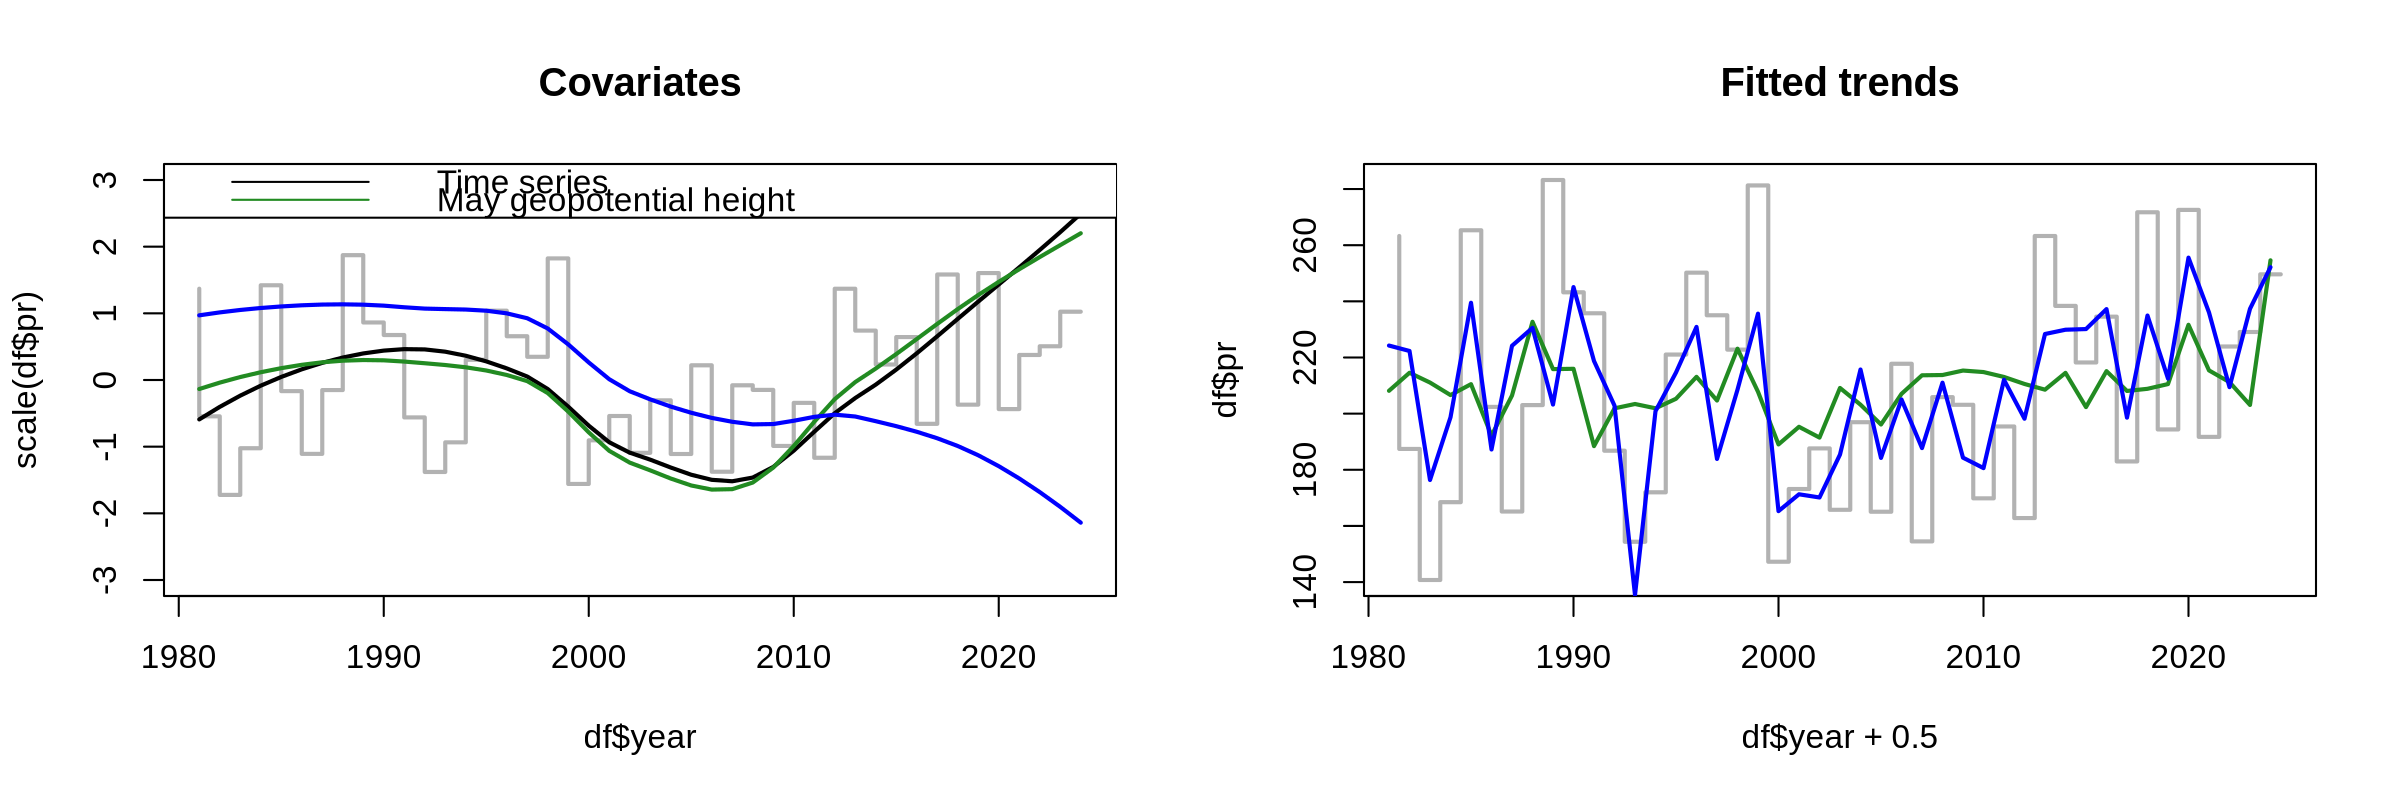

In [11]:
plot(df$year, scale(df$pr), type = "S", lwd = 2, ylim = c(-3,3), col = adjustcolor("black", 0.3), main = "Covariates")
lines(df$year, scale(fitted(loess(pr ~ year, df, span = ls))), col = "black", lwd = 2)
lines(df$year, scale(fitted(loess(gph ~ year, df, span = ls))), col = "forestgreen", lwd = 2)
lines(df$year, scale(fitted(loess(gradient ~ year, df, span = ls))), col = "blue", lwd = 2)

legend("topleft", legend = c("Time series", "May geopotential height"), col = c("black", "forestgreen", "blue"), lty = 1)

plot(df$year+0.5, df$pr, type = "S", lwd = 2, col = adjustcolor("black", 0.3), main = "Fitted trends")
lines(df$year, fitted(loess(pr ~ gph, df, span = ls)), col = "forestgreen", lwd = 2)
lines(df$year, fitted(loess(pr ~ gph + gradient, df, span = ls)), col = "blue", lwd = 2)

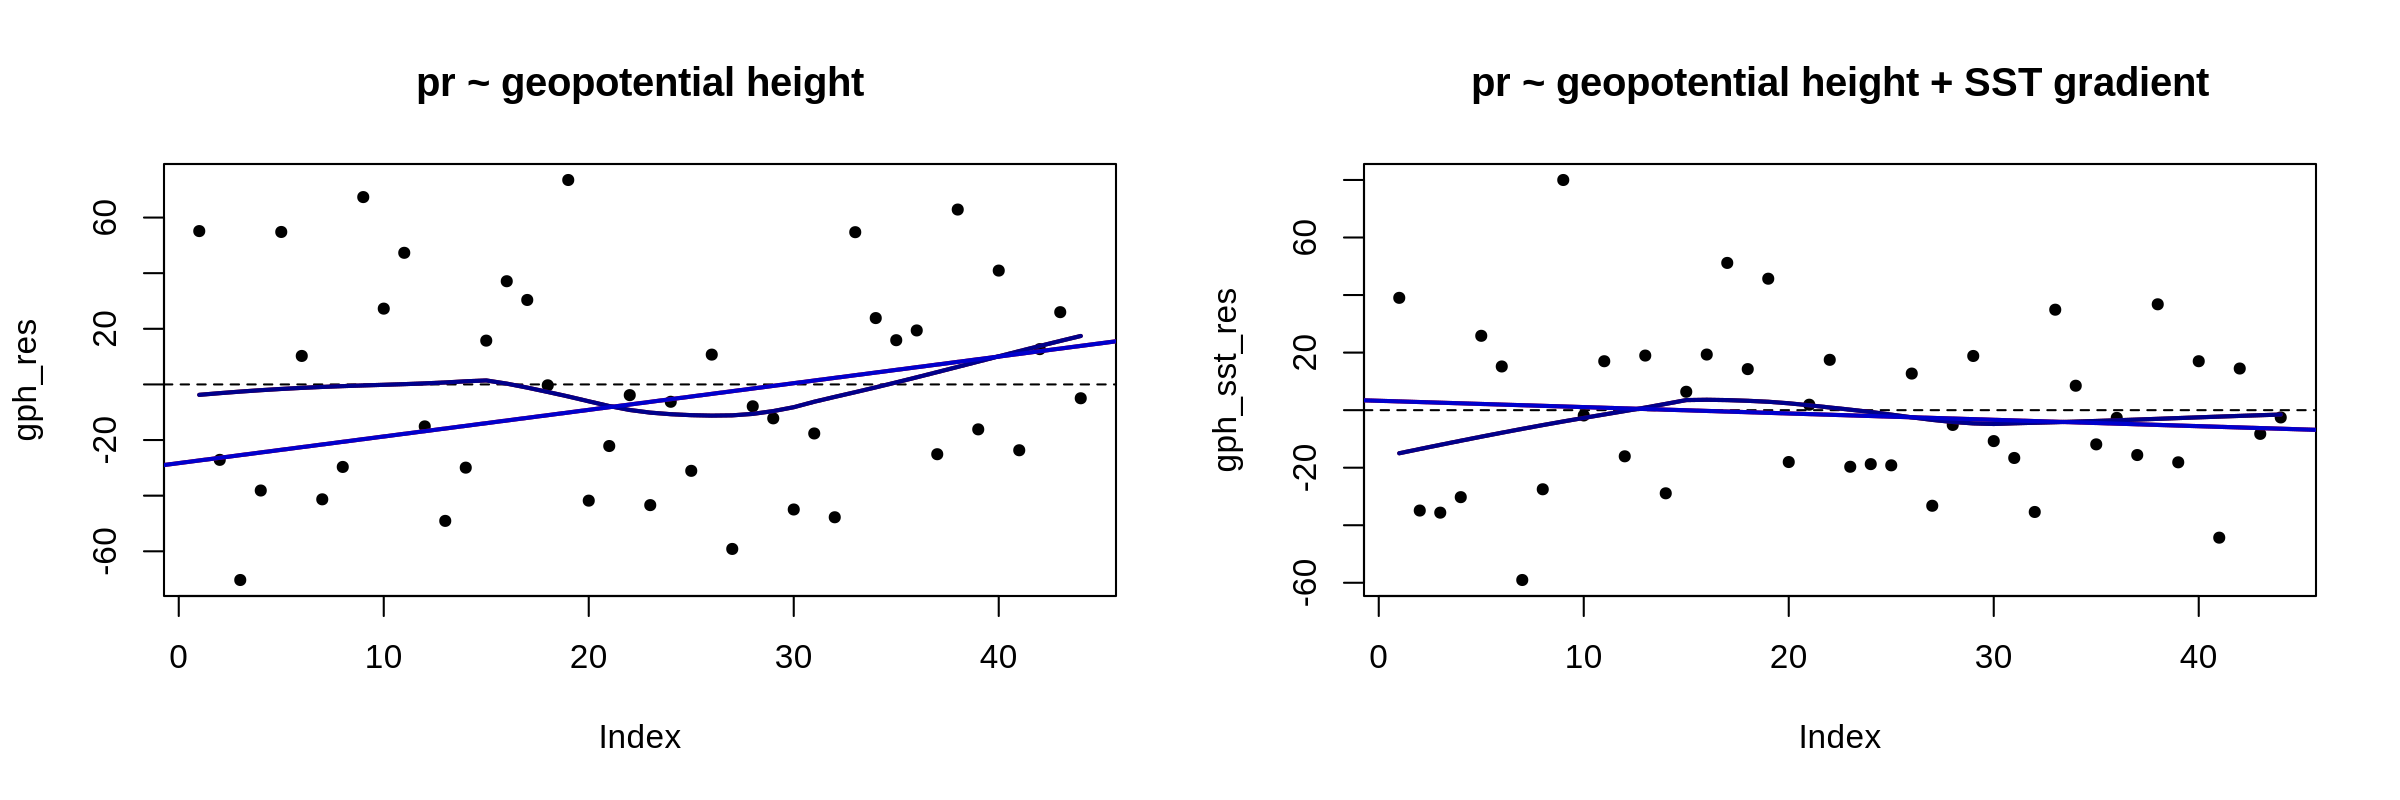

In [18]:
# what's left in the residuals?
prep_window(c(1,2), h = 4, w = 6)

gph_res <- resid(loess(pr ~ gph, df, span = ls))
gph_res_1979 <- resid(loess(pr ~ gph, df[df$year >= 1979,], span = ls))

plot(gph_res, main = "pr ~ geopotential height")
abline(h = 0, lty = 2)
lines(lowess(gph_res), col = "darkred", lwd = 2)
abline(line(gph_res), col = "red3", lwd = 2)
lines(lowess(gph_res_1979), col = "darkblue", lwd = 2)
abline(line(gph_res_1979), col = "blue3", lwd = 2)

gph_sst_res <- resid(loess(pr ~ gph + gradient, df, span = ls))
gph_sst_res_1979 <- resid(loess(pr ~ gph + gradient, df[df$year >= 1979,], span = ls))

plot(gph_sst_res, main = "pr ~ geopotential height + SST gradient")
abline(h = 0, lty = 2)
lines(lowess(gph_sst_res), col = "darkred", lwd = 2)
abline(line(gph_sst_res), col = "red3", lwd = 2)
lines(lowess(gph_sst_res_1979), col = "darkblue", lwd = 2)
abline(line(gph_sst_res_1979), col = "blue3", lwd = 2)

### Nonstationary GEV

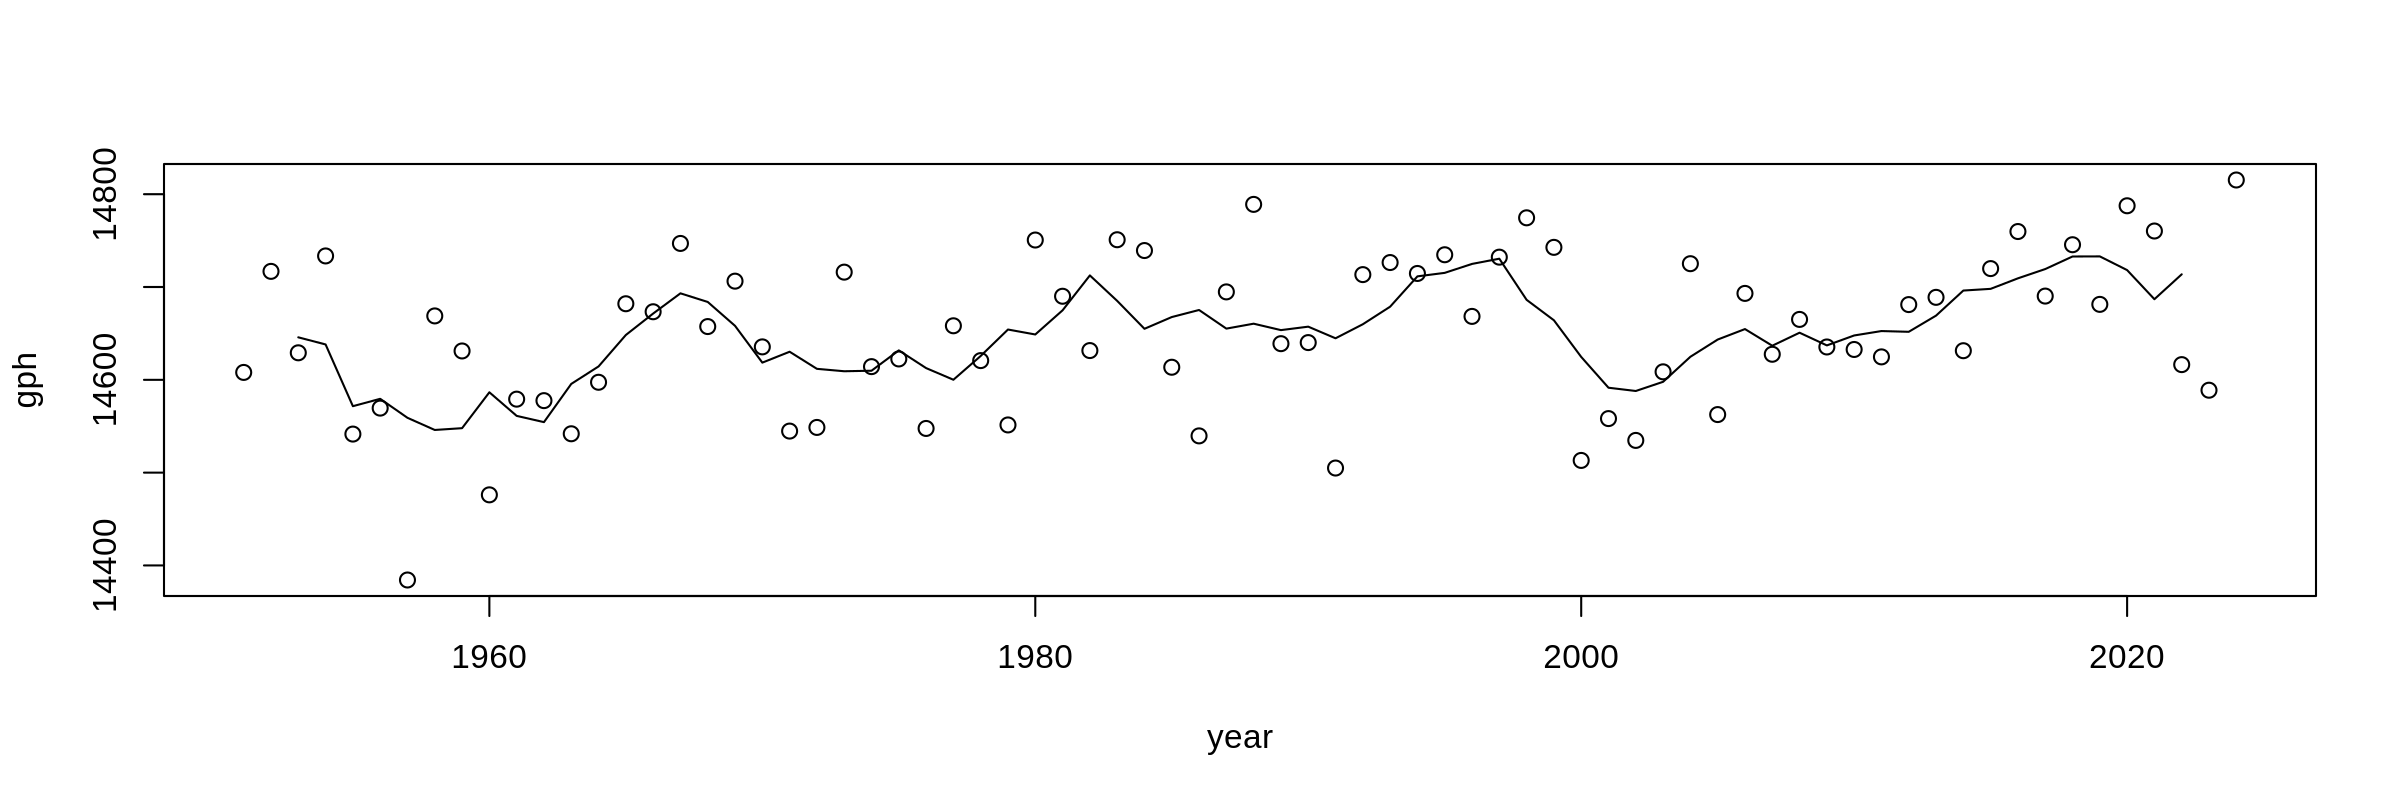

In [24]:
plot(gph)
lines(gph$year, filter(gph$gph, rep(1/5,5, sides = 1)))

In [138]:
models_gph <- sapply(datasets, function(ds) {
    df <- merge(gph, load_ts(paste0("ts_obs/EA-floods_rx30day_obs-org_",ds,".dat"), col.names = c("year", "pr")))
    fit_ns("gev", "fixeddisp", df, "pr", c("gph_sc"), lower = F)
}, simplify = F)

models_gph_sst <- sapply(datasets, function(ds) {
    df <- merge(sstg, merge(gph, load_ts(paste0("ts_obs/EA-floods_rx30day_obs-org_",ds,".dat"), col.names = c("year", "pr"))))
    fit_ns("gev", "fixeddisp", df, "pr", c("gph_sc", "gradient_sc"), lower = F)
}, simplify = F)

In [139]:
rbind("pr ~ gph" = sapply(models_gph, aic), "pr ~ gph + sst" = sapply(models_gph_sst, aic))

,chirps,cpc,era5,mswep,tamsat
pr ~ gph,451.8874,463.0775,761.4996,465.9329,412.1540
pr ~ gph + sst,453.8080,460.9591,763.2352,465.5445,409.5544


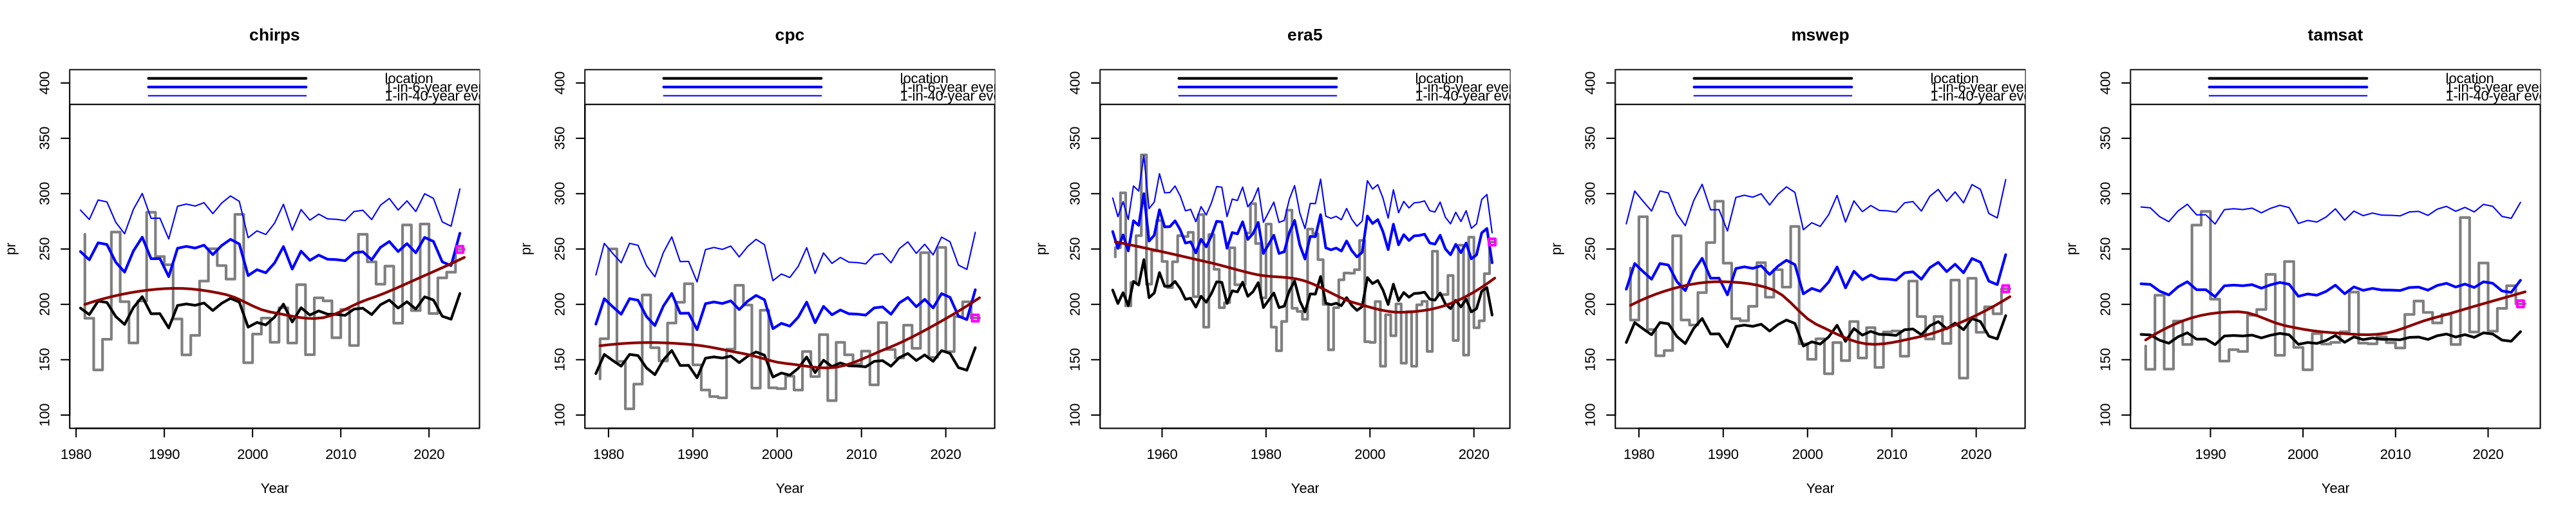

In [140]:
prep_window(c(1,5))
ylim <- c(100,400)

for (ds in datasets) {
    mdl <- models_gph[[ds]]
    plot_trend(mdl, ylim = ylim, main = ds)
    lines(mdl$data$year, fitted(loess(pr ~ year, mdl$data)), col = "darkred", lw = 2)
}

## Other modes of natural variability

In [177]:
nino = load_ts("ts_obs/EA-floods_nino-djf_obs_ersst.dat", col.names = c("year", "nino"))
iod = load_ts("ts_obs/EA-floods_iod-mam_obs_ersst.dat", col.names = c("year", "iod"))

df <- merge(merge(gmst, nino), iod)

# define factual & counterfactual covariates
cov_2024 <- df[df$year == 2024,c("gmst", "nino", "iod"), drop = F]

cov_cf <- rbind("pi" = cov_2024 - c(1.2,0,0),
                "nino_neut" = c("gmst" = cov_2024$gmst, "nino" = 0, "iod" = cov_2024$iod),
                "iod_neut" = c("gmst" = cov_2024$gmst, "nino" = cov_2024$nino, "iod" = 0))

### Nino

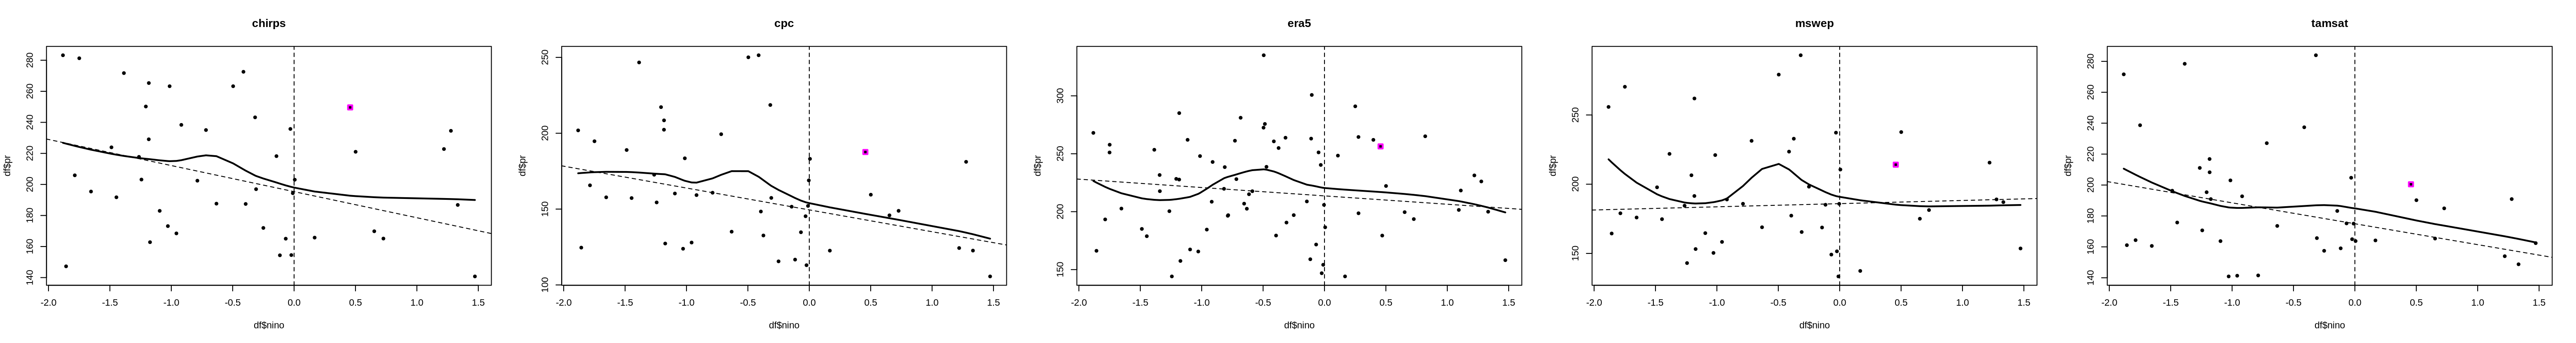

In [198]:
prep_window(c(1,5), h = 4, w = 6)

for (ds in datasets) {
    df <- merge(merge(nino, get(ds)), gph)
    df <- df[order(df$nino),]
    plot(df$nino, df$pr, pch = 20, main = ds)
    abline(v = 0, lty = 2)
    points(df[df$year == 2024,c("nino", "pr")], col = "magenta", pch = 0, lwd = 2)
    
    lines(df$nino, fitted(loess(pr ~ nino, df)), col = "black", lwd = 2)
    abline(line(df$nino, df$pr), lty = 2)
}

### IOD

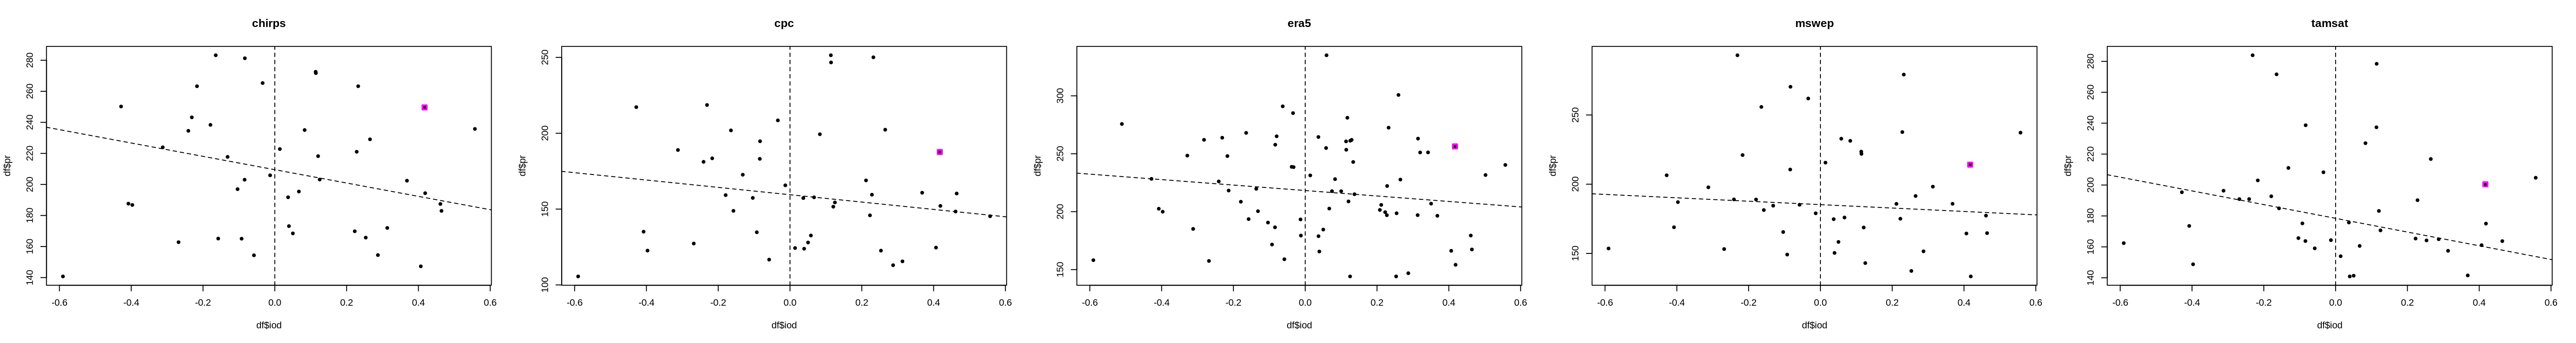

In [200]:
prep_window(c(1,5), h = 4, w = 6)

for (ds in datasets) {
    df <- merge(merge(iod, get(ds)), gph)
    df <- df[order(df$iod),]
    plot(df$iod, df$pr, pch = 20, main = ds)
    abline(v = 0, lty = 2)
    points(df[df$year == 2024,c("iod", "pr")], col = "magenta", pch = 0, lwd = 2)
    
#     lines(df$iod, fitted(loess(pr ~ iod, df)), col = "black", lwd = 2)
    abline(line(df$iod, df$pr), lty = 2)
}

### Compare fitted models

In [6]:
# Bootstrap model fit - GMST + Nino
nsamp <- 1000
for (ds in datasets) {
    
    fnm <- paste0("ts/EA-floods_",varnm,"_",region,"_",ds,".dat")
    res_fnm <- gsub(".dat", ".csv", gsub("ts/", "res/res-gmst-nino_", fnm))
    if(!file.exists(res_fnm)) {
        ts <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(gmst, nino), ts)

        mdl <- fit_ns("gev", "fixeddisp", df, "pr", c("gmst", "nino"), lower = F)
        res <- boot_ci(mdl, cov_f = cov_2024, cov_cf = cov_cf, nsamp = nsamp)
        
        # get correlation between Nino3.4 and rainy season precip, for evaluation
        set.seed(42)
        nino_corr <- c(cor(df$nino, df$pr), quantile(sapply(1:nsamp, function(i) cor(df[sample(1:nrow(mdl$data), replace = T), c("nino", "pr")])[1,2]), c(0.025, 0.975)))
                                                   
        write.csv(rbind(res, nino_corr), res_fnm)
    }
}

In [101]:
# Bootstrap model fit - GMST + IOD
nsamp <- 1000
for (ds in datasets) {
    
    fnm <- paste0("ts/EA-floods_",varnm,"_",region,"_",ds,".dat")
    res_fnm <- gsub(".dat", ".csv", gsub("ts/", "res/res-gmst-iod_", fnm))
    if(!file.exists(res_fnm)) {
        ts <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(merge(gmst, nino), iod), ts)

        mdl <- fit_ns("gev", "fixeddisp", df, "pr", c("gmst", "iod"), lower = F)
        res <- boot_ci(mdl, cov_f = cov_2024, cov_cf = cov_cf, nsamp = nsamp)
        
        # get correlation between Nino3.4 and rainy season precip, for evaluation
        set.seed(42)
        nino_corr <- c(cor(df$nino, df$pr), quantile(sapply(1:nsamp, function(i) cor(df[sample(1:nrow(mdl$data), replace = T), c("nino", "pr")])[1,2]), c(0.025, 0.975)))
                                                   
        write.csv(rbind(res, nino_corr), res_fnm)
    }
}

## Full region (original shapefile including central Tanzania)

### Compare AIC & RMSE

In [12]:
region <- "highlands-box"
varnm <- "rx30day"

In [13]:
rmse <- function(mdl) mean((mdl$x - ns_pars(mdl)$loc)^2)^{1/2}

In [ ]:
models_gmst <- sapply(datasets, function(ds) {
    df_ds <- merge(df, load_ts(paste0("ts/EA-floods_",varnm,"_obs-",region,"_",ds,".dat"), col.names = c("year", "pr")))
    mdl <- fit_ns("gev", "fixeddisp", df_ds, "pr", c("gmst"), lower = F) 
}, simplify = F)

In [ ]:
models_nino <- sapply(datasets, function(ds) {
    df_ds <- merge(df, load_ts(paste0("ts/EA-floods_",varnm,"_obs-",region,"_",ds,".dat"), col.names = c("year", "pr")))
    mdl <- fit_ns("gev", "fixeddisp", df_ds, "pr", c("gmst", "nino"), lower = F)
}, simplify = F)

models_iod <- sapply(datasets, function(ds) {
    df_ds <- merge(df, load_ts(paste0("ts/EA-floods_",varnm,"_obs-",region,"_",ds,".dat"), col.names = c("year", "pr")))
    mdl <- fit_ns("gev", "fixeddisp", df_ds, "pr", c("gmst", "iod"), lower = F)
}, simplify = F)

models_nino_iod <- sapply(datasets, function(ds) {
    df_ds <- merge(df, load_ts(paste0("ts/EA-floods_",varnm,"_obs-",region,"_",ds,".dat"), col.names = c("year", "pr")))
    mdl <- fit_ns("gev", "fixeddisp", df_ds, "pr", c("gmst", "nino", "iod"), lower = F)
}, simplify = F)

In [133]:
rbind("gmst" = sapply(models_gmst, aic), "gmst + nino" = sapply(models_nino, aic), "gmst + iod" = sapply(models_iod, aic), "gmst + nino + iod" = sapply(models_nino_iod, aic))

,chirps,cpc,mswep,tamsat
gmst,446.7220,458.2732,473.8616,420.8199
gmst + nino,442.6278,455.3125,473.5884,420.2332
gmst + iod,448.0142,460.1691,475.8385,418.6886
gmst + nino + iod,443.9780,457.2834,475.5214,418.1099


In [137]:
rbind("gmst" = sapply(models_gmst, rmse), "gmst + nino" = sapply(models_nino, rmse), "gmst + iod" = sapply(models_iod, rmse), "gmst + nino + iod" = sapply(models_nino_iod, rmse))

,chirps,cpc,mswep,tamsat
gmst,43.20946,39.86487,42.56692,38.43178
gmst + nino,39.74854,37.64571,40.97090,36.53229
gmst + iod,42.77148,39.78412,42.57421,38.24951
gmst + nino + iod,39.40233,37.58866,40.90336,36.37795


### Return level plots

In [144]:
nsamp = 10
dist = "gev"

prep_window(c(length(datasets), 4), h = 3, w = 5)
png(paste0("fig/rlplots_",dist,"-fixeddisp.png"), h = 360 * 4, w = 600*4); par(cex.main = 1.2); {
    par(mfrow = c(length(datasets), 4))
    for (ds in datasets) {

        df_ds <- merge(df, load_ts(paste0("ts/EA-floods_rx30day_obs_",ds,".dat"), col.names = c("year", "pr")))
        mdl_gmst <- fit_ns(dist, "fixeddisp", df_ds, "pr", c("gmst", "nino"), lower = F)
        mdl_nino <- fit_ns(dist, "fixeddisp", df_ds, "pr", c("gmst", "nino"), lower = F)
        mdl_iod <- fit_ns(dist, "fixeddisp", df_ds, "pr", c("gmst", "iod"), lower = F)
        mdl_both <- fit_ns(dist, "fixeddisp", df_ds, "pr", c("gmst", "nino", "iod"), lower = F)

        plot_returnlevels(mdl_gmst, cov_f = cov_2024, cov_cf = cov_cf["pi",,drop = F], legend_pos = NA, main = paste0(ds, " - GMST only"), nsamp = nsamp)
        plot_returnlevels(mdl_nino, cov_f = cov_2024, cov_cf = cov_cf["pi",,drop = F], legend_pos = NA, main = paste0(ds, " - GMST + Nino"), nsamp = nsamp)
        plot_returnlevels(mdl_iod, cov_f = cov_2024, cov_cf = cov_cf["pi",,drop = F], legend_pos = NA, main = paste0(ds, " - GMST + IOD"), nsamp = nsamp)
        plot_returnlevels(mdl_both, cov_f = cov_2024, cov_cf = cov_cf["pi",,drop = F], legend_pos = NA, main = paste0(ds, " - Nino + IOD"), nsamp = nsamp)
    }
}; dev.off()

png 
  2

### Parameter estimates for different models

In [ ]:
# load all the bootstrapped results
res_gmst_nino <- abind::abind(sapply(datasets, function(ds) {
    read.csv(paste0("res/res-gmst-nino_EA-floods_rx30day_obs_",ds,".csv"), row.names = "X")
}, simplify = F), along = 0)
rownames(res_gmst_nino) <- datasets

In [27]:
models <- c("gmst", "gmst-nino")

all_res <- abind::abind(sapply(models, function(mtype) {
    abind::abind(sapply(datasets, function(ds) {
        read.csv(paste0("res/res-",mtype,"_EA-floods_rx30day_obs_",ds,".csv"), row.names = "X")[1:16,]
    }, simplify = F), along = 0)
}, simplify = F), along = 0)
rownames(all_res) <- models
colnames(all_res) <- datasets

In [162]:
nc <- length(datasets)
empty <- matrix(NA,nc,3)

gmst_res <- abind::abind(sapply(datasets, function(ds) {
        read.csv(paste0("res/res-gmst_EA-floods_rx30day_obs_",ds,".csv"), row.names = "X")
    }, simplify = F), along = 0)
gmst_res <- abind::abind(gmst_res[,1:3,], "alpha_nino" = empty, "alpha_iod" = empty, gmst_res[,4:ncol(gmst_res),], "nino_corr" = empty, along = 2)

gmst_nino_res <- abind::abind(sapply(datasets, function(ds) {
        read.csv(paste0("res/res-gmst-nino_EA-floods_rx30day_obs_",ds,".csv"), row.names = "X")
    }, simplify = F), along = 0)
gmst_nino_res <- abind::abind(gmst_nino_res[,1:4,], "alpha_iod" = empty, gmst_nino_res[,5:ncol(gmst_nino_res),], along = 2)

gmst_iod_res <- abind::abind(sapply(datasets, function(ds) {
        read.csv(paste0("res/res-gmst-iod_EA-floods_rx30day_obs_",ds,".csv"), row.names = "X")
    }, simplify = F), along = 0)
gmst_iod_res <- abind::abind(gmst_iod_res[,1:3,], "alpha_nino" = empty, gmst_iod_res[,4:ncol(gmst_iod_res),], along = 2)

# compile
all_res <- abind::abind("gmst" = gmst_res, "gmst + nino" = gmst_nino_res, "gmst + iod" = gmst_iod_res, along = 0)
all_res[!is.finite(all_res)] <- NA
all_res[all_res == 0] <- NA
all_res[all_res == 1] <- NA

nr <- nrow(all_res)

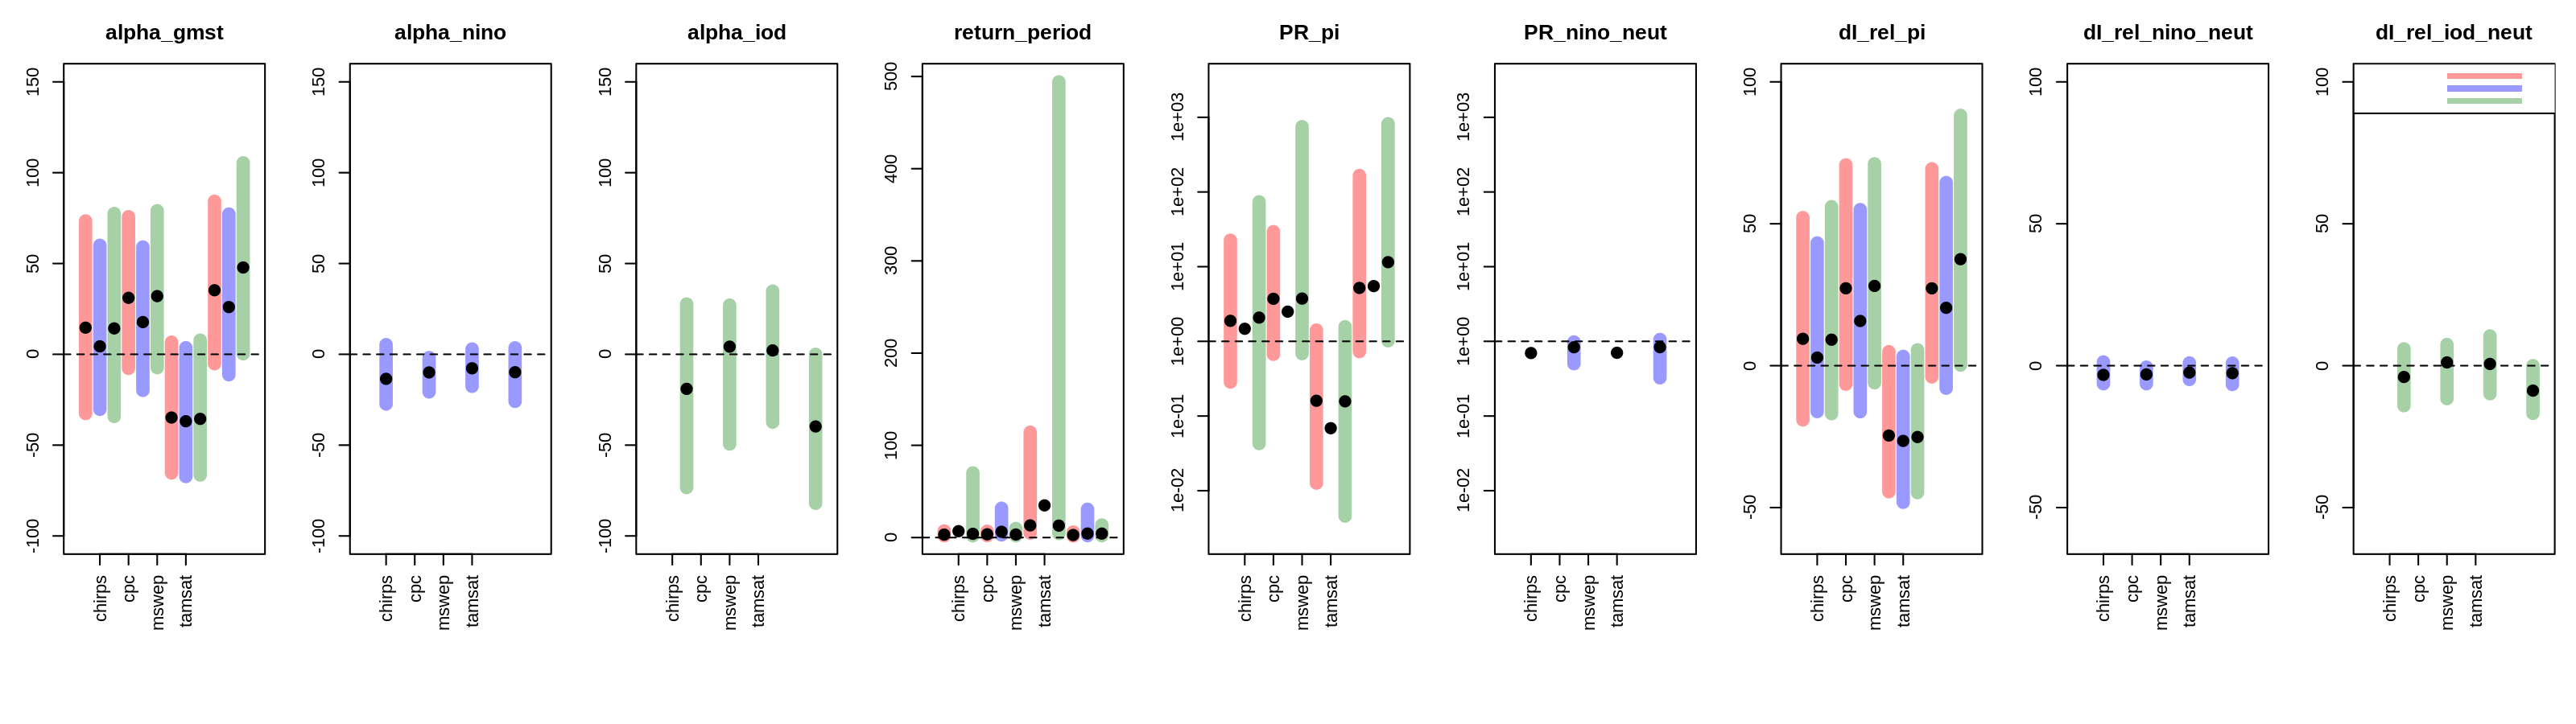

In [163]:
plot_pars <- c("alpha_gmst", "alpha_nino", "alpha_iod", "return_period", "PR_pi", "PR_nino_neut", "dI_rel_pi", "dI_rel_nino_neut", "dI_rel_iod_neut")

ds_colours <- adjustcolor(c("red", "blue", "forestgreen", "purple"), alpha = 0.4)[1:nr]
prep_window(c(1,4), h = 4.5); par(mar = c(8,3,3,1))

    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        res <- all_res[,,r,]
        res[!is.finite(res)] <- NA
        ylim = range(res, na.rm = T)
        logaxs = ""
        h = 0
        
        nr <- nrow(res)
        if(grepl("alpha", r)) {
            ylim = range(pretty(all_res[,,grepl("alpha", dimnames(all_res)[[3]]),]), na.rm = T)
        } else if(grepl("dI_abs", r)) {
            ylim = range(pretty(all_res[,,grepl("dI_abs", dimnames(all_res)[[3]]),]), na.rm = T)
        } else if(grepl("dI_rel", r)) {
            ylim = range(pretty(all_res[,,grepl("dI_rel", dimnames(all_res)[[3]]),]), na.rm = T)
        } else if(grepl("PR", r)) {
            h = 1
            logaxs = "y"
            ylim = exp(range(pretty(log(all_res[,,grepl("PR", dimnames(all_res)[[3]]),])), na.rm = T))
        }
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,nr*nc+1), main = r, xaxt = "n", xlab = "", ylab = "", log = logaxs)
        axis(1, at = (1:nc)*(nr-1), labels = colnames(res), las = 2)
        segments(x0 = 1:(nr*nc), y0 = res[,,"X2.5."], y1 = res[,,"X97.5."], lwd = 8, col = ds_colours)
        points(1:(nr*nc), res[,,"est"], pch = 20, cex = 2)
        abline(h = h, lty = 2)
    }
legend("topleft", legend = rownames(all_res), fill = ds_colours, border = NA)

### Fitted trend plots

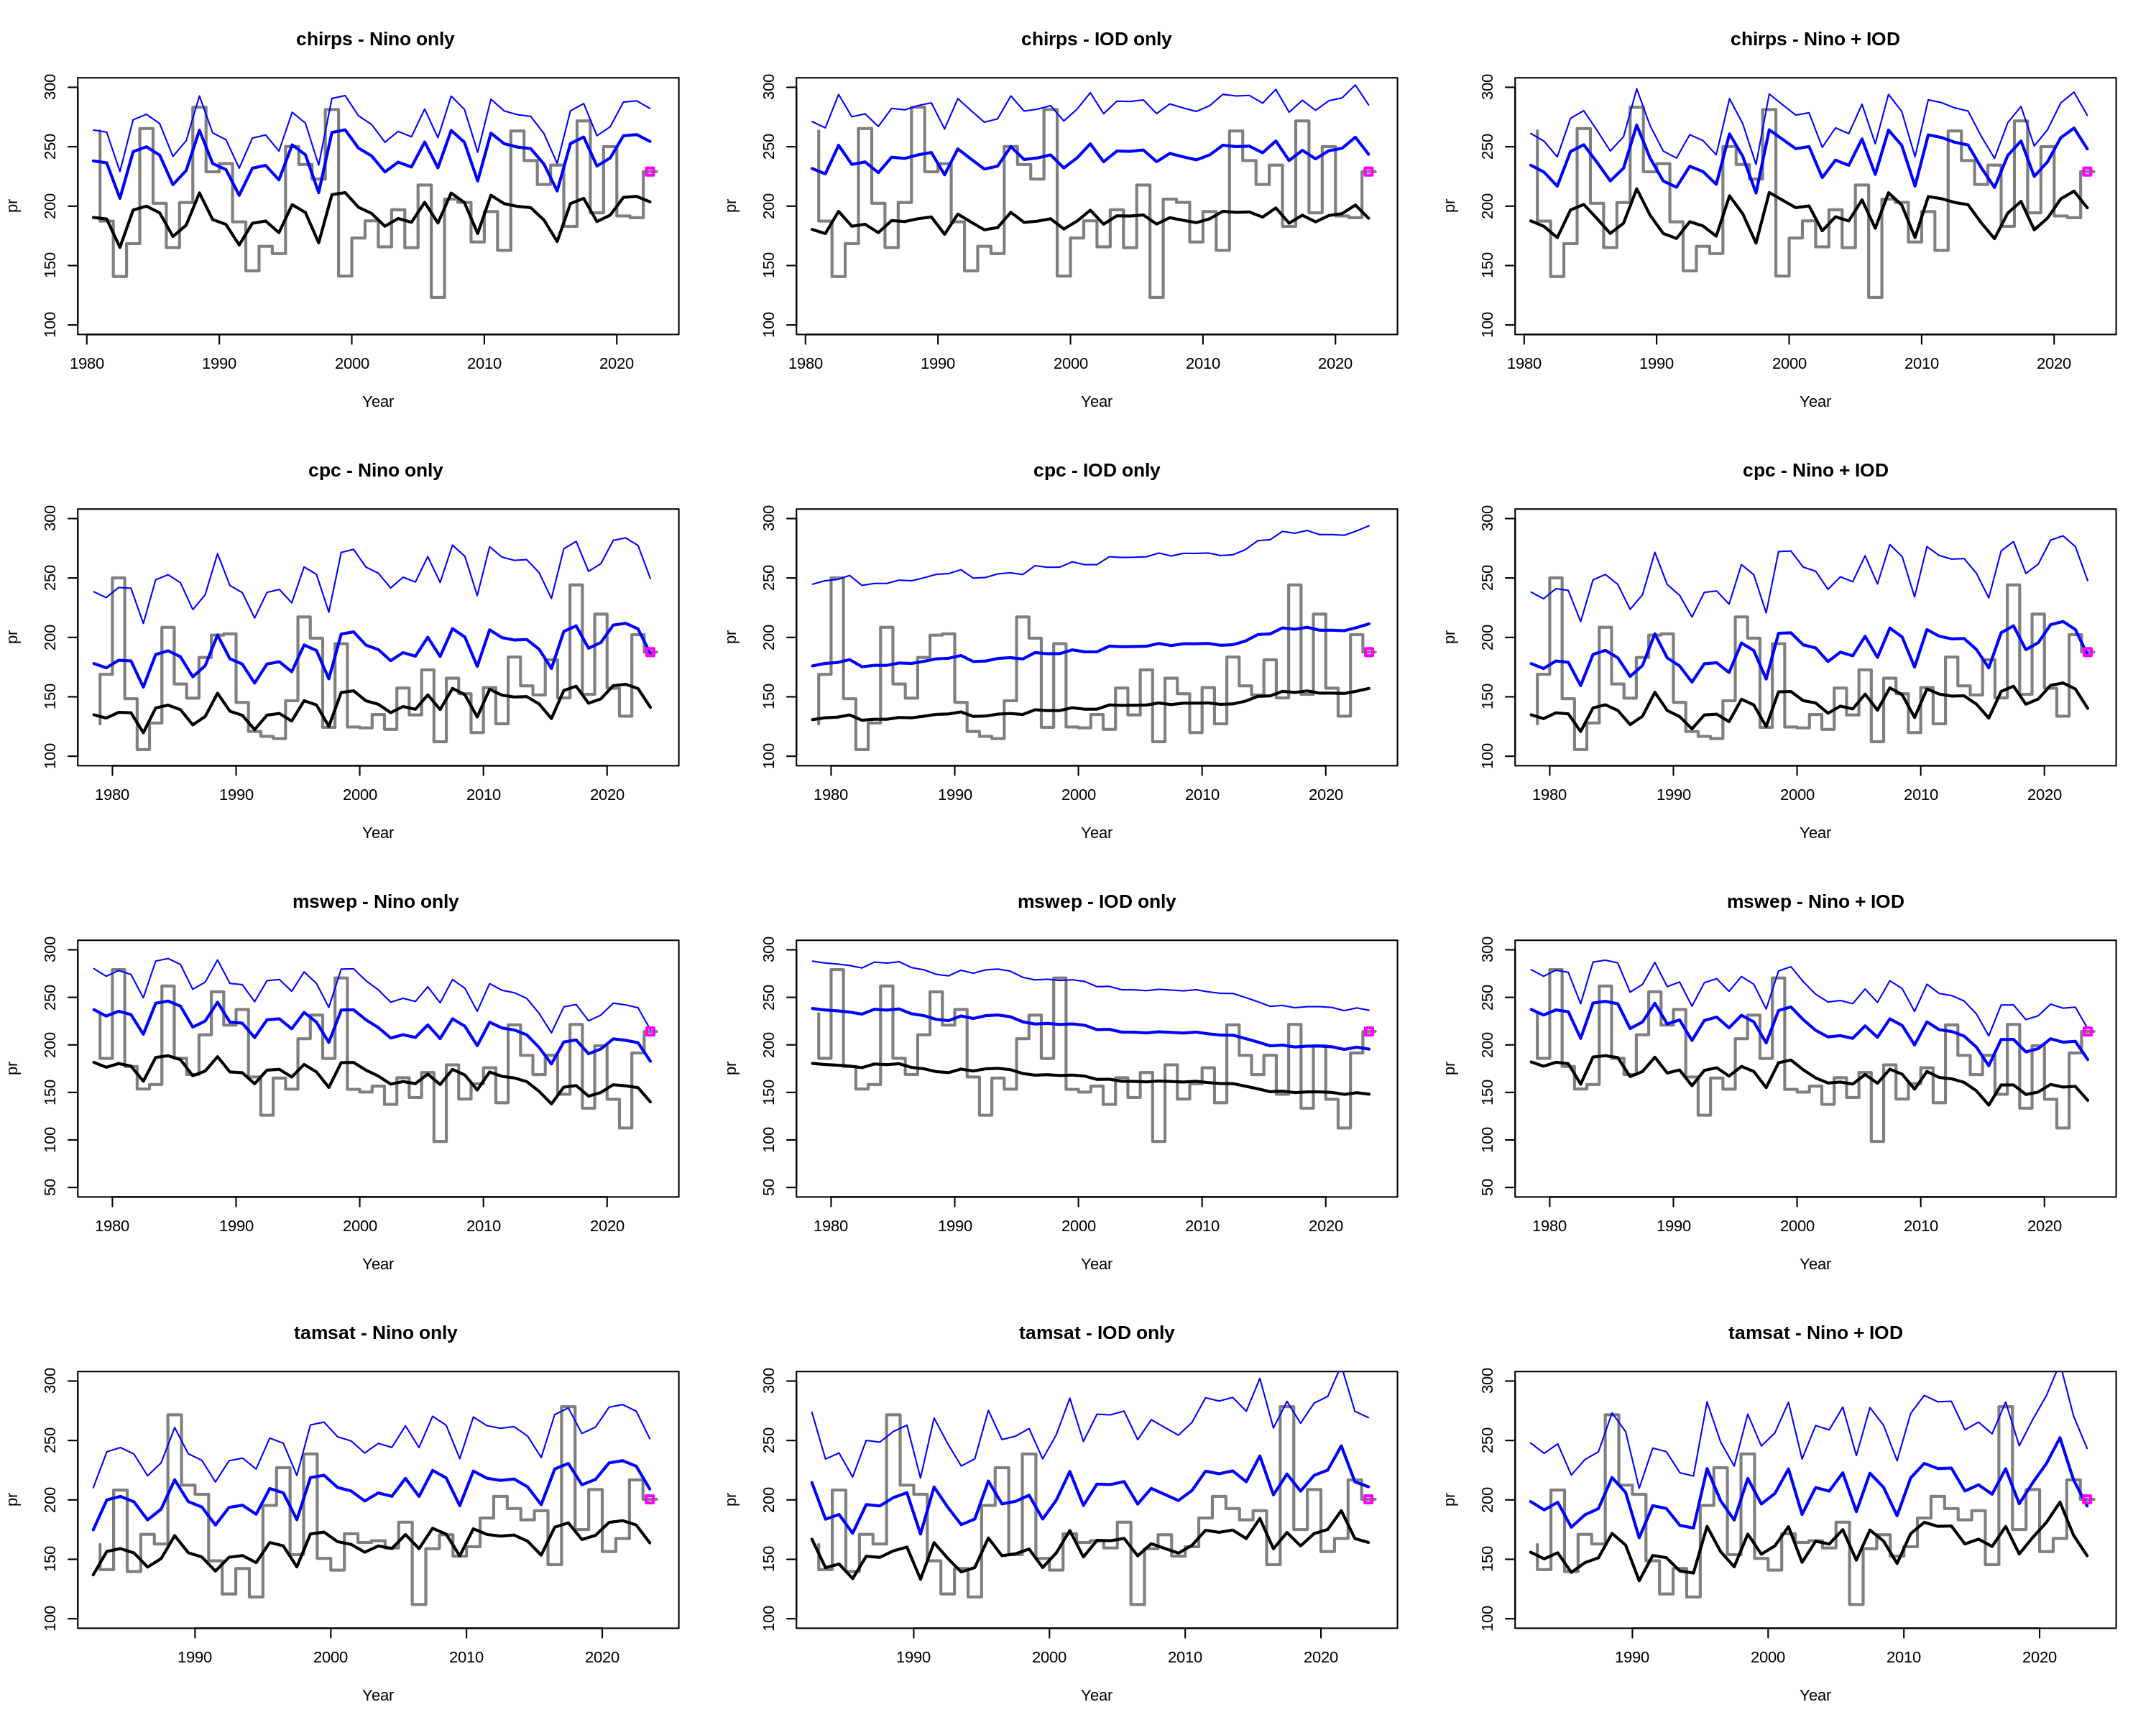

In [76]:
prep_window(c(length(datasets), 3), h = 3, w = 5)
for (ds in datasets) {
    
    df_ds <- merge(df, load_ts(paste0("ts/EA-floods_rx30day_obs_",ds,".dat"), col.names = c("year", "pr")))
    mdl_nino <- fit_ns("gev", "fixeddisp", df_ds, "pr", c("gmst", "nino"), lower = F)
    mdl_iod <- fit_ns("gev", "fixeddisp", df_ds, "pr", c("gmst", "iod"), lower = F)
    mdl_both <- fit_ns("gev", "fixeddisp", df_ds, "pr", c("gmst", "nino", "iod"), lower = F)
    
    plot_trend(mdl_nino, legend_pos = NA, main = paste0(ds, " - Nino only "))
    plot_trend(mdl_iod, legend_pos = NA, main = paste0(ds, " - IOD only"))
    plot_trend(mdl_both, legend_pos = NA, main = paste0(ds, " - Nino + IOD"))
}

### Residuals

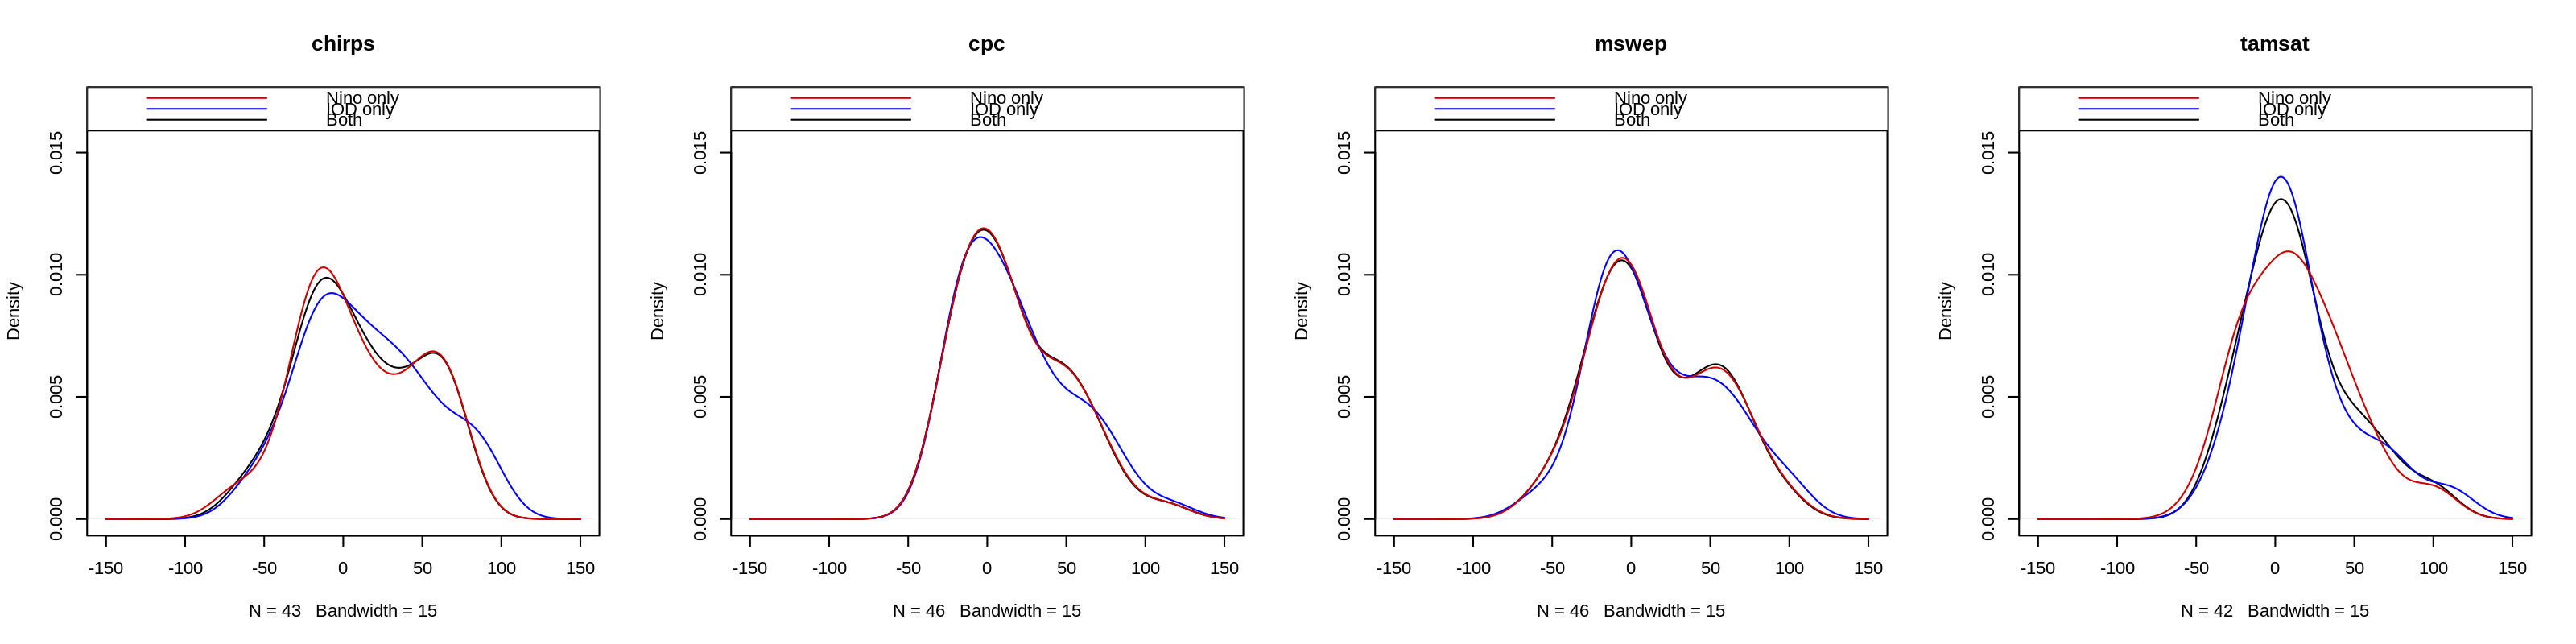

In [122]:
# Distribution of residuals from each model
prep_window(c(1,4))
for (ds in datasets) {
    mdl_n <- models_nino[[ds]]
    mdl_i <- models_iod[[ds]]
    mdl_in <- models_nino_iod[[ds]]
    
    plot(density(mdl_in$x - ns_pars(mdl_in)$loc, from = -150, to = 150, bw = 15), col = "black", main = ds, ylim = c(0,0.017), xlim = c(-150,150))
    lines(density(mdl_i$x - ns_pars(mdl_i)$loc, from = -150, to = 150, bw = 15), col = "blue")
    lines(density(mdl_n$x - ns_pars(mdl_n)$loc, from = -150, to = 150, bw = 15), col = "red3")
    
    legend("topleft", c("Nino only", "IOD only", "Both"), lty = 1, col = c("red3", "blue", "black"))
}

# Fit linear model to gridded data

In [2]:
datasets = c("chirps", "cpc", "mswep", "tamsat")
varnm = "rx30day"

gmst = read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

# define factual & counterfactual covariates
cov_2024 <- gmst[gmst$year == 2024,"gmst", drop = F]
cov_cf <- rbind("pi" = cov_2024 - c(1.2,0,0))

In [3]:
fl = list.files("data/flattened", pattern = varnm, full.names = T)
for(fnm in fl) {
    
    res_fnm <- gsub("flattened", "gridded-res", fnm)
    
    if (!file.exists(res_fnm)) {
        df <- read.csv(fnm, skip = 3, header = F)
        colnames(df)[1] <- "year"
        df <- merge(gmst, df)

        # fit nonstationary model to all grid cells
        models <- sapply(colnames(df)[grepl("V", colnames(df))], function(cnm) {
            df_c <- df[,c("year", "gmst", cnm)]
            tryCatch({
                fit_ns("gev", "fixeddisp", df_c, cnm, c("gmst"), lower = F)
            }, error = function(cond) { return(NULL) })
        }, simplify = F)

        # get all model results & save as .csv to be reconstructed & plotted in python
        fitted_res <- sapply(models, function(mdl) {
            if(!is.null(unlist(mdl)[1])) {
                mdl_ests(mdl, cov_f = cov_2024, cov_cf = cov_cf)
            } else {
                rep(NA, 10)
            }})
        write.csv(fitted_res, res_fnm)
    }
}

# HighResMIP

In [5]:
gmst = read.table("ts_obs/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

# define factual & counterfactual covariates
cov_2024 <- gmst[gmst$year == 2024,c("gmst"), drop = F]
cov_pi <- cov_2024 - 1.2
cov_fut <- cov_2024 + 0.8

In [ ]:
# Bootstrap model fit - GMST only
nsamp <- 1000
for (region in regions[1]) {
    fl <- list.files("ts_highresmip", pattern = region, full.names = T)
    for (fnm in fl) {
        mdl <- strsplit(fnm,"_")[[1]][5]
        res_fnm <- paste0("res/",region,"/res-gmst_EA-floods_rx30day_highresmip-",region,"_",mdl,".csv")

        if(!file.exists(res_fnm)) {
            ts <- load_ts(fnm, col.names = c("year", "pr"))
            df <- merge(gmst, ts)
            mdl <- fit_ns("gev", "fixeddisp", df, "pr", c("gmst"), lower = F)
            res <- cmodel_results(mdl, rp = 10, cov_f = cov_2024, cov_hist = cov_pi, cov_fut = cov_fut, nsamp = nsamp)                                 
            write.csv(res, res_fnm)
        }
    }
}

In [44]:
# compile results
for (rnm in c('org', 'lt', 'lv', 'ch', 'tc', "box")) {
    res <- t(sapply(list.files(paste0("res/",rnm), pattern = "highresmip", full.names = T), read.csv, row.names = "X"))
    rownames(res) <- sapply(strsplit(gsub(".csv", "", rownames(res)), "_"), "[", 5)
    write.csv(res, paste0("res/res-highresmip_gmst_",rnm,".csv"))
}


### Parameter estimates

In [30]:
# load all the bootstrapped results (maybe not for all regions)
regions = c('org', 'lt', 'lv', 'ch', 'tc') 

all_res <- abind::abind(sapply(regions, function(rnm) {
    abind::abind(sapply(list.files(paste0("res/",rnm), pattern = "highresmip", full.names = T), function(fnm) {
        read.csv(fnm, row.names = "X")
    }, simplify = F), along = 0)
}, simplify = F), along = 0)

In [31]:
plot_pars <- c("alpha_gmst", "return_period", "PR", "dI_rel", "dI_abs")
ds_colours <- c("red", "blue", "forestgreen", "purple", "turquoise4", "pink", "gold")

prep_window(c(1,4), h = 4.5, w = 5); 

# png("fig/par-ests_gmst_highresmip.png", height = 240, w = 4 * 240 * 5/4); par(cex.main = 1.4, mar = c(8,3,3,1)); {
    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        res <- all_res[,,r,]
        res[!is.finite(res)] <- NA
        ylim = range(res, na.rm = T)
        logaxs = ""
        h = 0
        
        res <- aperm(res, c(2,1,3))
        
        nc <- ncol(res)
        nr <- nrow(res)
        
        nr <- nrow(res)
        if(grepl("alpha", r)) {
            ylim = range(pretty(all_res[,,grepl("alpha", dimnames(all_res)[[3]]),]), na.rm = T)
        } else if(grepl("dI_abs", r)) {
            ylim = range(pretty(all_res[,,grepl("dI_abs", dimnames(all_res)[[3]]),]), na.rm = T)
        } else if(grepl("dI_rel", r)) {
            ylim = range(pretty(all_res[,,grepl("dI_rel", dimnames(all_res)[[3]]),]), na.rm = T)
        } else if(grepl("return_period", r)) {
            ylim = c(0,50)
        } else if(grepl("PR", r)) {
            h = 1
            logaxs = "y"
            ylim = exp(range(pretty(log(all_res[,,grepl("PR", dimnames(all_res)[[3]]),])), na.rm = T))
            ylim = c(1/100, 100)
        }
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,nr*(nc+1)), main = r, xaxt = "n", xlab = "", ylab = "", log = logaxs)
        axis(1, at = (1:nr)*(nc+1) - (nc+1)/2, labels = rownames(res), las = 2)
        
        for (i in 1:nr) {
            x <- ((i-1)*(nc+1))+(1:nc)
            segments(x0 = x, y0 = res[i,,"X2.5."], y1 = res[i,,"X97.5."], lwd = 8, col = adjustcolor(ds_colours, alpha = 0.4))
            points(x, res[i,,"est"], pch = 21, cex = 1.5, bg = ds_colours)
        }
        abline(h = h, lty = 2)
            
        abline(v = (0:nr)*(nc+1), col = adjustcolor("black", alpha = 0.3))
    }
    legend("topleft", legend = colnames(res), fill = adjustcolor(ds_colours, alpha = 0.4), border = NA, ncol = 2)
# }; dev.off()

ERROR: Error in all_res[, , r, ]: subscript out of bounds


# CORDEX

In [47]:
rp = 10
nsamp = 1000

rnm <- "org"

# currently no Nino data for EC-EARTH
fl <- list.files("ts_cordex", pattern = rnm, full.names = T)

In [80]:
for (fnm in fl) {
    
    mnm <- paste0(gsub(".dat","",strsplit(fnm, "_")[[1]][5:6]), collapse = "_")
    
    gmst_fnm <- list.files("ts_cordex", pattern = paste0("smoothed-gsat_", strsplit(fnm, "_")[[1]][5]), full.names = T)
    if(length(gmst_fnm) == 0) {
        cat("GMST missing:", mnm)
        next
    }
                           
    # load data & combine all covariates with time series
    df <- merge(load_ts(fnm, col.names = c("year", "pr")), load_ts(gmst_fnm, col.names = c("year", "gmst")))
    mdl <- fit_ns("gev", "fixeddisp", df, "pr", "gmst", lower = F)
    res_fnm <- paste0("res/",rnm,"/res-gmst_EA-floods_rx30day_cordex-",rnm,"_",mnm,".csv")
                           
    if(!file.exists(res_fnm)) {
        
        # use model's 2023 GMST & observed Nino to define factual climate        
        cov_now <- df[df$year == 2024,"gmst",drop = F]
        cov_hist <- cov_now - 1.2
        cov_fut <- cov_now + 0.8

        # bootstrap results
        res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut,
                             y_now = 2024, y_start = 1979, y_fut = 2050, nsamp = nsamp)
        write.csv(res, res_fnm)
    }
                                       
    # quick return level plots to check fit
    rlplot_fnm <- gsub("csv", "png", gsub("res/", "mdl-eval/rlplot_", res_fnm))
    if(!file.exists(rlplot_fnm)) {
        png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
            plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = mnm)
        }; dev.off()
    }
}

In [95]:
# compile results
for (rnm in c('org', 'lt', 'lv', 'ch', 'tc', "box")[1]) {
    res <- t(sapply(list.files(paste0("res/",rnm), pattern = "cordex", full.names = T), read.csv, row.names = "X"))
    rownames(res) <- sapply(rownames(res), function(r) gsub(".csv","",paste0(strsplit(r, "_")[[1]][5:6], collapse = "_")))
    write.csv(res, paste0("res/res-cordex_gmst_",rnm,".csv"))
}